## Deterministic Capacity Expansion Model

In [1]:
using Pkg
using JuMP
using Gurobi
using XLSX
using PlotlyJS
using DataFrames
using CSV
using Dates

In [2]:
# configurations
dir = "data/data.xlsx";  # input directory
power = ["P_Nuclear","P_Coal_Hardcoal","P_Gas","RES_Wind_Onshore_Avg","RES_Wind_Offshore_Transitional","RES_PV_Utility_Avg"]
h2 = ["X_Electrolysis"]
dispatch = ["P_Nuclear","P_Coal_Hardcoal","P_Gas"]
nondispatch = ["RES_Wind_Onshore_Avg","RES_Wind_Offshore_Transitional","RES_PV_Utility_Avg"]
year_ts = 2010
tdelta = 10
colour_codes = Dict(
    "P_Nuclear" => "rgb(112,112,112)",
    "Load"=> "orange",
    "X_Electrolysis"=>  "rgb(191,0,191)",
    "P_Coal_Hardcoal" => "rgb(229,229,229)",
    "P_Gas" => "rgb(224,91,9)",
    "LL" => "red",
    "RES_Wind_Offshore_Transitional" => "rgb(104,149,221)",
    "RES_Wind_Onshore_Avg" => "rgb(35,94,188)",
    "RES_PV_Utility_Avg" => "rgb(249,208,2)",
);


#### 1. Mathematical Formulation

\begin{align}
\min & \sum_{y \in Y} (\dfrac{1}{(1+r)^{y- y_{start}}}(CAPEX_y + \sum_{s \in S} (\pi_s \cdot (OPEX_y + CLL_{y})))) \\

\text{s.t.} & \sum_{g \in power} (GEN_{s,y,g,t} \cdot \eta_{g})+LL_{s,y,t}-z_{s,d,power,y,t} \cdot d_{power_y}-\sum_{g \in H2} GEN_{s,y,g,t}=0   \quad \forall g \in G, \quad \forall y \in Y, \quad \forall t \in T\\
& CAPEX_y = \sum_{g \in G} (CAP_{new,y,g}  \cdot c_{CAPEX,y,g}) \quad \forall g \in G, \quad \forall y \in Y \\ 
& OPEX_y = \sum_{g \in G} (CAP_{y,g} \cdot c_{fix,g}+\sum_{t \in T} (GEN_{s,y,g,t} \cdot c_{var,g})) \cdot EM_{s,y} \cdot e_y \cdot \Delta t \quad \forall g \in G, \quad \forall y \in Y, \quad \forall t \in T\\
& GEN_{s,y,g,t} \leq cap_{g,y} \quad \forall g \in G_{disp}, \quad \forall y \in Y, \quad \forall t \in T \\
& GEN_{s,y,g,t} \leq cap_{g,y} \cdot z_{y,t,g} \quad \forall g \in G_{nondisp}, \quad \forall y \in Y, \quad \forall t \in T \\
& \sum_{g \in H2, t \in T} (GEN_{s,g,y,t}\cdot \eta_g) \leq d_{H2,y} \quad \forall y \in Y, \quad \forall t \in T\\
& CAP_{y,g} = CAP_{new,y,g} + CAP_{acc,y,g} + c_{res,y,g} \quad \forall y \in Y_{start+1}, \quad \forall g \in G \\
& CAP_{acc,y,g} = \sum_{\hat{y} \in Y, \hat{y} \leq y} CAP_{y,g} \quad \forall y \in Y, \quad \forall g \in G \\
& CAP_{y,g} = c_{res,g} \quad \forall g \in G, \quad \forall y \in Y_{start} \\ 
& CAP_{y,g} \leq c_{max,g,y} \quad \forall g \in G, \quad \forall y \in Y \\
& EM_{s,y} = \sum_{g \in G} (\sum_{g \in G} (GEN_{s,y,g,t} \cdot e_g)) \quad \forall g \in G, \quad \forall y \in Y, \quad \forall t \in T  \\
& CLL_{s,y} = \sum_{t \in T} (LL_{s,y,t} \cdot c_{ll}) \quad \forall y \in Y, \quad \forall t \in T \\ 
& OPEX_{s,y} \geq 0 \quad \forall y \in Y \\
& CAPEX_y \geq 0 \quad \forall y \in Y \\
& CAP_{new,y,g} \geq 0 \quad \forall y \in Y,\quad \forall g \in G \\
& GEN_{s,y,g,t } \geq 0 \quad \forall y \in Y, \quad \forall g \in G,\quad \forall t \in T \\
& CLL_{s,y} \geq 0  \quad \forall y \in Y \\
& LL_{s,y,t} \geq 0 \quad \forall y \in Y, \quad \forall t \in T \\
& CAP_{y,g} \geq 0 \quad \forall y \in Y, \quad \forall g \in G \\
& EM_{s,y} \geq 0 \quad \forall y \in Y \\
\end{align}

In [3]:
function read_data(dir, sheet_name::String)
    df = DataFrame(XLSX.readtable(dir, sheet_name))
    # Create a dictionary for indexing
    index_dict = Dict()

    # Iterate through DataFrame rows and populate the dictionary
    for row in eachrow(df)
        key = sheet_name in ["d_h2", "d_power", "emission_penalty"] ? (row.Year) :
        sheet_name in ["lifetime", "emission"] ? (row.Generator) :
        (row.Generator, row.Year)
        index_dict[key] = row.Value
    end
    return index_dict
end

read_data (generic function with 1 method)

In [5]:
function read_res_time_series(dir_lst, Timestep, Scenario, nondispatch)
    # Create a DenseAxisArray 
    df = JuMP.Containers.DenseAxisArray(zeros(length(nondispatch), length(Scenario), length(Timestep)),nondispatch, Scenario, Timestep)

    for i in dir_lst
        ts = DataFrame(CSV.File(i))
        for col in Scenario
            for t in Timestep
                try
                    df[split(split(i, ".")[1], "/")[2], col, t] = ts[t, string(col)]  
                catch err
                    df[split(split(i, ".")[1], "/")[2],col, t] = 0
                end
            end
        end
    end
    return df
end

read_res_time_series (generic function with 1 method)

In [6]:
function read_demand_time_series(path, Timestep, Scenario)
    ts = DataFrame(CSV.File(path))
    # Create a DenseAxisArray 
    df = JuMP.Containers.DenseAxisArray(zeros(length(Scenario), length(Timestep)), Scenario, Timestep)

    for col in Scenario
        for t in Timestep
            try
                df[col, t] = ts[t, string(col)]  
            catch err
                df[col, t] = 0
            end
        end
    end
    return df
end


read_demand_time_series (generic function with 1 method)

### 2. Formulation in Julia

In [7]:
# Sets
𝓢 = 2010:2011; # scenarios
𝓖 = ["P_Nuclear","P_Coal_Hardcoal","P_Gas","RES_Wind_Onshore_Avg","RES_Wind_Offshore_Transitional","RES_PV_Utility_Avg","X_Electrolysis"];       
𝓨 = 2020:10:2050
𝓣 = 1:8760; # time-steps

In [8]:
# Parameters
c_ll = 50000;                                        # cost for lost load
c_fix = read_data(dir, "c_fix");                    # fixed costs
c_var = read_data(dir, "c_var");                    # variable costs
c_capex = read_data(dir, "c_CAPEX");                # investment costs
cap_max = read_data(dir, "cap");                        # max capacity investment per year
r = 0.05;                                           # interest rate
η = read_data(dir, "eta");                          # efficiency
π = fill(1/10, 10);                                 # probability
lifetime = read_data(dir, "lifetime")               # lifetime of generators
cap_res = read_data(dir, "cap_init")               # residual capacity in 2020
e = read_data(dir, "emission") # emission content per generators
e_pen = read_data(dir, "emission_penalty") # emission penalty for fossil fuel generators
d_power = read_data(dir, "d_power")                 # power demand level annual
d_h2 = read_data(dir, "d_h2")                       # hydrogen demand https://ehb.eu/files/downloads/EHB-Analysing-the-future-demand-supply-and-transport-of-hydrogen-June-2021-v3.pdf
z_vres = read_res_time_series(["data/RES_Wind_Onshore_Avg.csv", "data/RES_Wind_Offshore_Transitional.csv", "data/RES_PV_Utility_Avg.csv"], 𝓣, 𝓢, nondispatch)                                      # availability of VRES
z_d = read_demand_time_series("data/Demand.csv", 𝓣, 𝓢);                                          # demand availability

In [9]:
model = Model()

# declaring the variables
@variable(model, gen[y in 𝓨,g in 𝓖,t in 𝓣] ≥ 0)         # planned generation for generators
@variable(model, opex[y in 𝓨] ≥ 0)                      # operation costs for generators
@variable(model, capex[y in 𝓨] ≥ 0)                     # capital investment costs for generators
@variable(model, cap_new[y in 𝓨,g in 𝓖] ≥ 0)           # new capacity investments for generators
@variable(model, ll[y in 𝓨, t in 𝓣] ≥ 0)               # lost load / ENS
@variable(model, cap[y in 𝓨,g in 𝓖] ≥ 0)                # old and new capacity for generators
@variable(model, cap_acc[y in 𝓨,g in 𝓖] ≥ 0)            # accumulated capacity according to lifetime for generators
@variable(model, em[y in 𝓨] ≥ 0)                        # emission CO2 per year

# defining constraints
@constraint(model, EnergyBalance[y in 𝓨, t in 𝓣], sum(gen[y, g, t] for g in power) + ll[y, t] - (z_d[year_ts,t] * d_power[y])  - (sum(gen[y,g,t] for g in h2)) == 0); # energy balance equation
@constraint(model, CAPEX[y in 𝓨], sum(cap_new[y,g]*c_capex[g,y] for g in 𝓖)==capex[y]);       # new capacity investments costs
@constraint(model, OPEX[y in 𝓨], (sum(cap[y,g]*c_fix[g,y]+sum(gen[y,g,t]*c_var[g,y] for t in 𝓣) for g in 𝓖)+(em[y]*e_pen[y]*1000))*tdelta==opex[y]);   # operational costs
@constraint(model, GenCapDisp[y in 𝓨, g in dispatch, t in 𝓣], gen[y,g,t] ≤ cap[y,g]* η[g, y]);    # limit max generation dispatchable
@constraint(model, GenCapH2[y in 𝓨, g in h2, t in 𝓣], gen[y,g,t] ≤ cap[y,g]);    # limit max generation hydrogen
@constraint(model,GenCapNonDisp[y in 𝓨, g in nondispatch, t in 𝓣], gen[y,g,t] ≤ cap[y,g]*z_vres[g,year_ts,t]); # max generation non dispatchable
@constraint(model, DemandH2[y in 𝓨], sum(gen[y,g,t]*η[g, y] for g in h2 for t in 𝓣) == d_h2[y]); # annual energy balance hydrogen
@constraint(model, InitialCap[y in 𝓨[1], g in 𝓖], cap[y,g] == (haskey(cap_res, (g,y)) ? cap_res[g,y] : 0));# initialize capacity in 2020

for g in 𝓖
    JuMP.fix(model[:cap_new][𝓨[1],g], 0; force=true);
    JuMP.fix(model[:cap_acc][𝓨[1],g], 0; force=true);
end
@constraint(model, NewCap[y in 𝓨[2:end], g in 𝓖], cap[y,g] == cap_acc[y,g]+cap_new[y,g] + (haskey(cap_res, (g,y)) ? cap_res[g,y] : 0)); # new capacity investments 
@constraint(model, AccCap[y in 𝓨[2:end], g in 𝓖], cap_acc[y,g] == sum(cap_new[hat_y,g] for hat_y in 𝓨[1]:10:y if y - 𝓨[1] ≤ lifetime[g])); # accumulated capacity  
@constraint(model, MaxCap[y in 𝓨[2:end], g in 𝓖], cap[y,g] ≤ cap_max[g,y]); # max potential capacity constraint
@constraint(model, EM[y in 𝓨], em[y] == sum(sum(gen[y,g,t]*e[g] for t in 𝓣) for g in keys(e))); # emission accounting

#@constraint(model, RESTarget[y in 𝓨], (sum(gen[y,g,t] for g in dispatch for t in 𝓣) - sum(gen[y,g,t] for g in h2 for t in 𝓣))*1/d_power[y] ≥ min_res[y]); # min res share on demand electricity excluding hydrogen demand

# define the objective 
@objective(model, Min, sum(1/((1+r)^(y-𝓨[1]))*(capex[y]+opex[y]+sum(ll[y,t]*c_ll for t in 𝓣)) for y in 𝓨));
## TODO Salvage value calculation
# TODO H2 value is missing
# TODO h2 efficiency and energy balance

┌ Warning: Axis contains one element: 2020. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[2020]` instead of `2020`.
└ @ JuMP.Containers /cluster/home/danare/.julia/packages/JuMP/R53zo/src/Containers/DenseAxisArray.jl:186


capex[2020] + opex[2020] + 50000 ll[2020,1] + 50000 ll[2020,2] + 50000 ll[2020,3] + 50000 ll[2020,4] + 50000 ll[2020,5] + 50000 ll[2020,6] + 50000 ll[2020,7] + 50000 ll[2020,8] + 50000 ll[2020,9] + 50000 ll[2020,10] + 50000 ll[2020,11] + 50000 ll[2020,12] + 50000 ll[2020,13] + 50000 ll[2020,14] + 50000 ll[2020,15] + 50000 ll[2020,16] + 50000 ll[2020,17] + 50000 ll[2020,18] + 50000 ll[2020,19] + 50000 ll[2020,20] + 50000 ll[2020,21] + 50000 ll[2020,22] + 50000 ll[2020,23] + 50000 ll[2020,24] + 50000 ll[2020,25] + 50000 ll[2020,26] + 50000 ll[2020,27] + 50000 ll[2020,28] + [[...34988 terms omitted...]] + 11568.872432792896 ll[2050,8731] + 11568.872432792896 ll[2050,8732] + 11568.872432792896 ll[2050,8733] + 11568.872432792896 ll[2050,8734] + 11568.872432792896 ll[2050,8735] + 11568.872432792896 ll[2050,8736] + 11568.872432792896 ll[2050,8737] + 11568.872432792896 ll[2050,8738] + 11568.872432792896 ll[2050,8739] + 11568.872432792896 ll[2050,8740] + 11568.872432792896 ll[2050,8741] + 11568

In [10]:
starttime= Dates.now()
optimizer = optimizer_with_attributes(
    () -> Gurobi.Optimizer(Gurobi.Env()),
    "LogToConsole" => 0,
    "Method" => 2,
    "BarHomogeneous" =>  1,
    "ResultFile" =>  "Solution_julia.sol"
)

set_optimizer(model, optimizer)

optimize!(model)

println(termination_status(model))
if termination_status(model) == MOI.INFEASIBLE_OR_UNBOUNDED || termination_status(model) == MOI.INFEASIBLE
    JuMP.compute_conflict!(model)
    list_of_conflicting_constraints = ConstraintRef[]
    for (F, S) in list_of_constraint_types(model)
        for con in all_constraints(model, F, S)
            if get_attribute(con, MOI.ConstraintConflictStatus()) == MOI.IN_CONFLICT
                push!(list_of_conflicting_constraints, con)
                        end
        end
    end
    
    open("/cluster/home/danare/git/IØ8403/iis.txt", "w") do file
        for r in list_of_conflicting_constraints
            println(r)
            write(file, string(r)*"\n")
        end
    end
else
    SP_solution = objective_value(model)
    println("\n\nObjective value is $SP_solution")
end
println(Dates.now() - starttime)

Set parameter TokenServer to value "gurobi.lisens.ntnu.no"
Set parameter Method to value 2
Set parameter BarHomogeneous to value 1
OPTIMAL




Objective value is 2.799324846893216e10
5912 milliseconds


## 3. Results

In [11]:
function plot_time_series(; df::JuMP.Containers.DenseAxisArray,year::Integer, title::String)
    years = axes(df)[1]
    generators = axes(df)[2]

    plots = [scatter(x=1:8760, y=df[year, g,:], name=g, stackgroup="one",marker_color=colour_codes[g]) for g in generators]
    append!(plots, [scatter(x=1:8760, y=z_d[year_ts,:]*d_power[year], name="Load", stackgroup="two", marker_color=colour_codes["Load"])])
    #append!([scatter(x=1:8760, y=ll[year,:], name="Lost Load", stackgroup="three", marker_color="red")], plots)
    plot(plots, Layout(title_text=title))
end

plot_time_series (generic function with 1 method)

In [12]:
function plot_results(; df::JuMP.Containers.DenseAxisArray, title::String)
    years = axes(df)[1]
    generators = axes(df)[2]
 
    plots = [bar(x=years, y=df[:, g], name=g, marker_color=colour_codes[g]) for g in generators]
    #append!([(x=years, y=df[:, "LL"], name="LL", marker_color="red")], plots)
    plot(plots, Layout(barmode="relative", title_text=title))
end    

plot_results (generic function with 1 method)

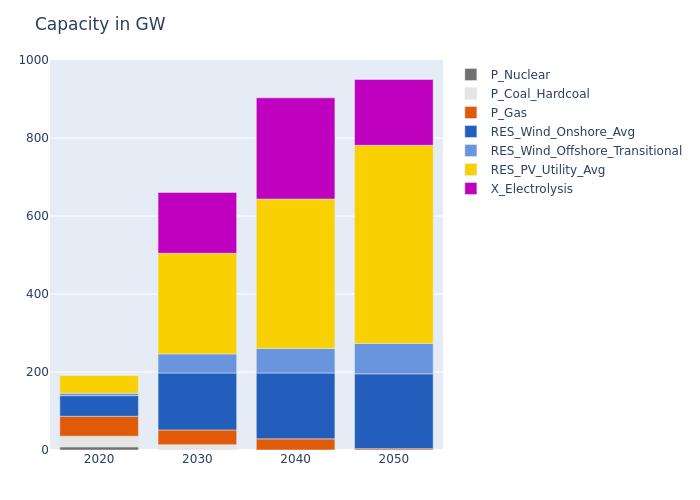

In [13]:
plot_results(df=value.(cap),title="Capacity in GW")
#TODO Anreize für H2 produktion
#TODO emission penalty

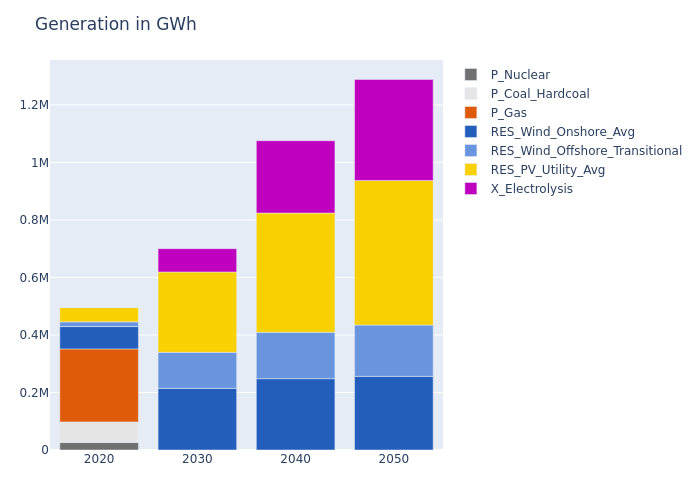

In [19]:
generation = (value.(gen))
generators = axes(generation)[2]
df_gen = JuMP.Containers.DenseAxisArray(zeros(length(axes(generation)[1]),length(generators)),axes(generation)[1], generators)
for i in axes(generation)[1] for j in generators
    for t in 𝓣
        df_gen[i, j] += generation[i,j,t]
    end
end end
plot_results(df=df_gen,title="Generation in GWh")


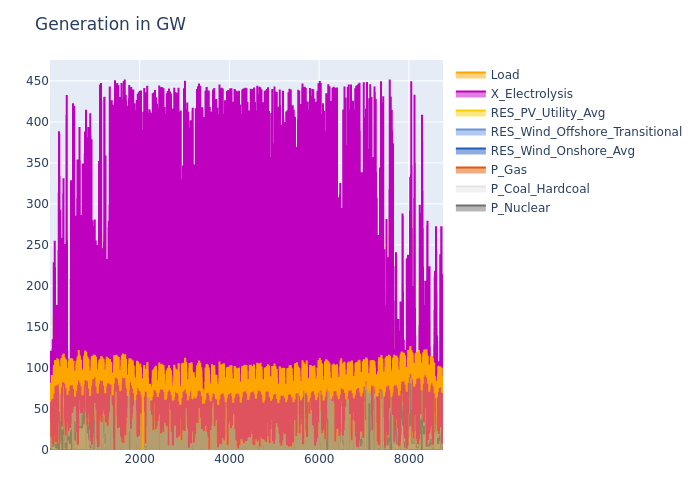

In [23]:
plot_time_series(df=value.(gen), title="Generation in GW", year=2050)

In [21]:
#plot_results(df=value.(gen),title="Capacity in GW")
for y in 2020:10:2050 
    println(value.(em)[y])
    println(value.(em)[y]*e_pen[y])
end
    #em[y]*e_pen[y]
value.(cap)

75.30771978944888
225923.15936834665
0.0
0.0
0.0
0.0
0.0
0.0


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 2020:10:2050
    Dimension 2, ["P_Nuclear", "P_Coal_Hardcoal", "P_Gas", "RES_Wind_Onshore_Avg", "RES_Wind_Offshore_Transitional", "RES_PV_Utility_Avg", "X_Electrolysis"]
And data, a 4×7 Matrix{Float64}:
 8.114  27.19  51.25   52.9   6.4   45.92    0.0
 0.0    13.5   38.0   146.0  49.0  258.0   156.03
 0.0     0.0   28.58  169.0  63.0  383.0   259.619
 0.0     0.0    3.4   192.0  78.0  508.0   168.817